In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import torch
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

### Load the training and test datasets

In [4]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

 basic information about the datasets

In [5]:
print("Training Set Shape:", df_train.shape)
print("Test Set Shape:", df_test.shape)
print("\nFirst Few Rows of the Training Data:")
print(df_train.head())

Training Set Shape: (7613, 5)
Test Set Shape: (3263, 4)

First Few Rows of the Training Data:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


Summarize null values and data types

In [6]:
print("\nInfo of Training Data:")
print(df_train.info())
print("\nInfo of Test Data:")
print(df_test.info())


Info of Training Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Info of Test Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [7]:
print("\nDistribution of the Target in the Training Set:")
print(df_train['target'].value_counts(normalize=True))


Distribution of the Target in the Training Set:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


### EDA

Missing values

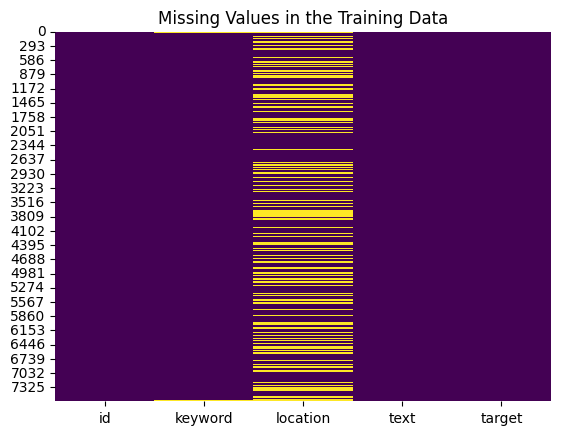

In [8]:
sns.heatmap(df_train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in the Training Data')
plt.show()

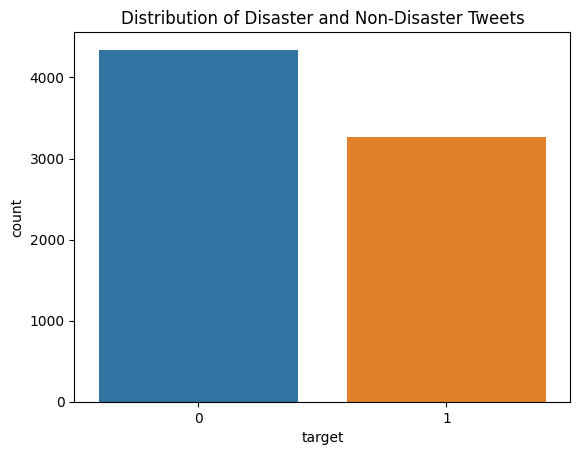

In [9]:
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Disaster and Non-Disaster Tweets')
plt.show()

Length of tweets

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


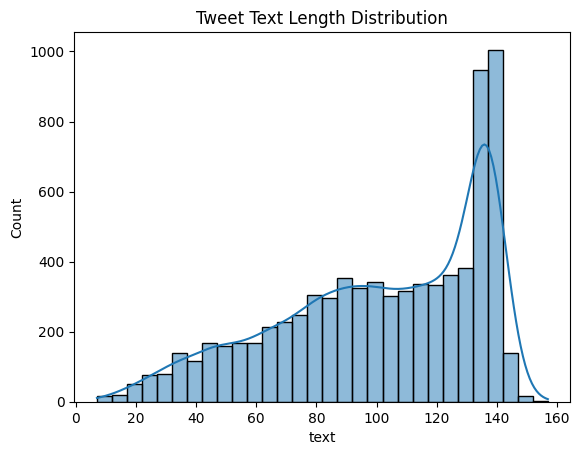

In [10]:
tweet_len = df_train['text'].str.len()
sns.histplot(tweet_len, bins=30, kde=True)
plt.title('Tweet Text Length Distribution')
plt.show()

#### Data Cleaning and Preprocessing

Removing URLs, HTML tags, and special characters using regex

In [11]:
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, flags=re.I | re.A)  # Remove special characters
    text = text.lower()  # Convert to lowercase to maintain consistency
    return text

In [12]:
df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

### Model Architecture

Tokenization

In [13]:
words = Counter()
for idx, row in df_train.iterrows():
    words.update(row['text'].split())

words = {word: i + 1 for i, word in enumerate(words)}
vocab_size = len(words) + 1  # +1 for padding

Convert text to sequence of numbers

In [14]:
def text_to_sequence(text, words):
    return [words[word] for word in text.split() if word in words]

df_train['text_seq'] = df_train['text'].apply(lambda x: text_to_sequence(x, words))
df_test['text_seq'] = df_test['text'].apply(lambda x: text_to_sequence(x, words))

Dataset creation

In [15]:
class DisasterDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.float)
        else:
            return torch.tensor(self.X[idx], dtype=torch.long)

Padding sequences and creating dataloaders

In [16]:
def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets = torch.tensor(targets)
    return inputs, targets

In [17]:
X_train, X_val, y_train, y_val = train_test_split(df_train['text_seq'], df_train['target'], test_size=0.1, random_state=42)

train_dataset = DisasterDataset(list(X_train), list(y_train))
val_dataset = DisasterDataset(list(X_val), list(y_val))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Model architecture

In [19]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden.squeeze(0))

In [20]:
model = RNN(vocab_size=vocab_size, embedding_dim=100, hidden_dim=256, output_dim=1, n_layers=2, bidirectional=True, dropout=0.5)
model = model.to(device)  # Move to GPU if available

In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training and evaluation

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    model.train()
    for texts, labels in iterator:
        texts = texts.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    predictions_all = []
    labels_all = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for texts, labels in iterator:
            texts = texts.to(device)
            labels = labels.to(device)

            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)

            # Apply sigmoid to predictions and round to get binary outputs
            preds = torch.round(torch.sigmoid(predictions))
            
            # Accumulate true and predicted labels for F1 score calculation
            predictions_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

            epoch_loss += loss.item()

    # Calculate F1 score along with precision and recall
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, predictions_all, average='binary')
    accuracy = accuracy_score(labels_all, predictions_all)
    
    return epoch_loss / len(iterator), accuracy, precision, recall, f1

In [23]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, criterion)

    print(f'Epoch: {epoch+1:02}')
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Val. Loss: {val_loss:.3f}, Val. Acc: {val_acc:.2f}, Val. Precision: {val_prec:.2f}, Val. Recall: {val_rec:.2f}, Val. F1: {val_f1:.2f}')

Epoch: 01
Train Loss: 0.648
Val. Loss: 0.602, Val. Acc: 0.69, Val. Precision: 0.78, Val. Recall: 0.40, Val. F1: 0.53
Epoch: 02
Train Loss: 0.577
Val. Loss: 0.568, Val. Acc: 0.72, Val. Precision: 0.70, Val. Recall: 0.64, Val. F1: 0.67
Epoch: 03
Train Loss: 0.526
Val. Loss: 0.585, Val. Acc: 0.73, Val. Precision: 0.70, Val. Recall: 0.69, Val. F1: 0.70
Epoch: 04
Train Loss: 0.491
Val. Loss: 0.557, Val. Acc: 0.75, Val. Precision: 0.79, Val. Recall: 0.57, Val. F1: 0.66
Epoch: 05
Train Loss: 0.462
Val. Loss: 0.533, Val. Acc: 0.76, Val. Precision: 0.73, Val. Recall: 0.70, Val. F1: 0.72
Epoch: 06
Train Loss: 0.435
Val. Loss: 0.540, Val. Acc: 0.76, Val. Precision: 0.78, Val. Recall: 0.62, Val. F1: 0.69
Epoch: 07
Train Loss: 0.400
Val. Loss: 0.581, Val. Acc: 0.76, Val. Precision: 0.85, Val. Recall: 0.55, Val. F1: 0.67
Epoch: 08
Train Loss: 0.368
Val. Loss: 0.591, Val. Acc: 0.77, Val. Precision: 0.84, Val. Recall: 0.60, Val. F1: 0.70
Epoch: 09
Train Loss: 0.349
Val. Loss: 0.627, Val. Acc: 0.76, Va

*Training Dynamics*: The model's training loss decreased steadily from 0.648 to 0.323 over ten epochs, indicating effective learning and adaptation to the training data. This suggests that the underlying architecture, presumably an RNN with LSTM units, was able to capture relevant patterns from the text data for disaster tweet classification.

*Validation Performance*: Validation accuracy improved from 0.69 to a peak of 0.77 by the eighth epoch but then slightly dropped to 0.75 by the tenth epoch. This pattern suggests the model was initially generalizing well but began to show signs of overfitting as training continued, evidenced by the increasing validation loss despite decreasing training loss.

*F1 Score Considerations*: The F1 score, which balances precision and recall, showed variability with a peak at 0.72 in the fifth epoch. Subsequent epochs did not maintain this level, fluctuating and generally trending downwards, indicating potential issues with model stability or overfitting as training progressed.

*Precision vs. Recall*: There was a notable trade-off observed between precision and recall throughout the training epochs. The model often achieved higher precision at the cost of lower recall, or vice versa, reflecting the challenges of achieving a balance between these metrics in disaster tweet classification.

### Overall

The training results suggest that while the model has learned effectively from the training data, there is room for improvement, particularly in terms of generalization to unseen data as indicated by the validation metrics. To address overfitting, implementing early stopping or experimenting with regularization techniques like dropout could be beneficial. Additionally, adjusting hyperparameters, including the learning rate and the number of LSTM units, may help enhance model performance and stability. Further explorations into advanced preprocessing and data augmentation techniques for NLP could also provide benefits.

#### Submition of results

In [24]:
test_dataset = DisasterDataset(list(df_test['text_seq']))  # No labels provided
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: pad_sequence(x, batch_first=True, padding_value=0))

In [25]:
def predict(model, iterator):
    model.eval()
    predictions = []

    with torch.no_grad():
        for texts in iterator:
            texts = texts.to(device)
            outputs = model(texts).squeeze(1)
            preds = torch.sigmoid(outputs)
            predicted_labels = (preds >= 0.5).int()  # Convert probabilities to binary output
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions

predictions = predict(model, test_loader)

In [26]:
# Ensure the test DataFrame has an 'id' column
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'target': predictions
})

In [27]:
submission_df.to_csv('submission.csv', index=False)